In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm, trange
import xml.etree.ElementTree as ET
import copy

In [2]:
dtype = torch.float32 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
widths = []
heights = []
for annotation_file in sorted(os.listdir('./annotations')):
    annotation_path = os.path.join('./annotations', annotation_file)

    # https://www.kaggle.com/bitthal/understanding-input-data-and-loading-with-pytorch
    tree = tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall('object')
    for obj in objects:
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        widths.append(xmax - xmin)
        heights.append(ymax - ymin)
        
np.mean(widths), np.mean(heights)

(31.149066797642437, 35.0049115913556)

In [4]:
total_num_images = 4072
train_indices = (0, int(0.80 * total_num_images))
val_indices = (int(0.80 * total_num_images), int(0.9 * total_num_images))
test_indices =  (int(0.9 * total_num_images), total_num_images)
train_indices, val_indices, test_indices

((0, 3257), (3257, 3664), (3664, 4072))

In [5]:
class FaceMaskDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, indices):
        self.img_dir = img_dir
        self.label_dict = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
        self.faces = []
        
        for annotation_file in sorted(os.listdir(annotations_dir)):
            annotation_path = os.path.join(annotations_dir, annotation_file)

            # https://www.kaggle.com/bitthal/understanding-input-data-and-loading-with-pytorch
            tree = tree = ET.parse(annotation_path)
            root = tree.getroot()
            filename = root.find('filename').text
            objects = root.findall('object')
            for obj in objects:
                label = self.label_dict[obj.find('name').text]
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                bbox = (xmin, ymin, xmax, ymax)
                self.faces.append((filename, bbox, label))
        
        self.faces = self.faces[indices[0]:indices[1]]
                        
    def __len__(self):
        return len(self.faces)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.faces[idx][0])
        img = Image.open(image_path).convert('RGB')
        cropped_img = img.crop(self.faces[idx][1])
        # Normalize stats from ImageNet
        compose = T.Compose([
            T.Resize((35, 35)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
        return compose(cropped_img), self.faces[idx][2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 35, 35])


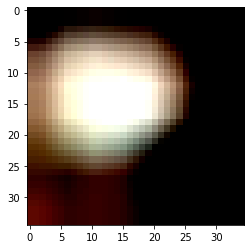

In [6]:
train_face_mask_dataset = FaceMaskDataset(img_dir='./images', annotations_dir='./annotations', indices=train_indices)
train_face_mask_dataloader = DataLoader(train_face_mask_dataset, batch_size=128, shuffle=True)

valid_face_mask_dataset = FaceMaskDataset(img_dir='./images', annotations_dir='./annotations', indices=val_indices)
valid_face_mask_dataloader = DataLoader(valid_face_mask_dataset, batch_size=128)

test_face_mask_dataset = FaceMaskDataset(img_dir='./images', annotations_dir='./annotations', indices=test_indices)
test_face_mask_dataloader = DataLoader(test_face_mask_dataset, batch_size=128)

# Boiler plate code to display some of the images
for img, label in DataLoader(FaceMaskDataset(img_dir='./images', annotations_dir='./annotations', indices=test_indices), batch_size=1):
    print(img.shape)
    plt.imshow(img.numpy()[0].transpose(1, 2, 0))
    break

In [7]:
len(train_face_mask_dataloader), len(valid_face_mask_dataloader), len(test_face_mask_dataloader)

(26, 4, 4)

In [8]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=3, bias=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Referenced Nikhil Pathak's ECE 176 Final Project on Image Colorization: https://github.com/nlpathak/ImageColorization
def evaluate(model, loss_func, current_best):
    losses = []
    accuracies = []
    
    model.eval() 
    with torch.no_grad():
        for imgs, labels in valid_face_mask_dataloader:
            imgs = imgs.to(device=device, dtype=dtype) 
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(imgs)
            
            losses.append(loss_func(scores, labels).item())
            accuracies.append(torch.sum(torch.argmax(scores, axis=1) == labels).item() / labels.shape[0])
    
    mean_loss = np.mean(losses)
    mean_acc = np.mean(accuracies)
    
    if mean_loss < current_best["loss"]:
        current_best["loss"] = mean_loss
        current_best["acc"] = mean_acc
        current_best["model"] = copy.deepcopy(model)
        
    return mean_loss, mean_acc, current_best
        
def train(model, optimizer, loss_func, epochs=1):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    current_best = {
        "loss": float('inf'),
        "acc": 0, 
        "model": model
    } 
    
    model = model.to(device=device) 
    for e in trange(epochs):
        epoch_loss = []
        epoch_acc = []
        for imgs, labels in train_face_mask_dataloader:
            model.train()  
            imgs = imgs.to(device=device, dtype=dtype)  
            labels = labels.to(device=device, dtype=torch.long)

            scores = model(imgs)
            loss = loss_func(scores, labels)
            
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            
            epoch_loss.append(loss.item())
            epoch_acc.append(torch.sum(torch.argmax(scores, axis=1) == labels).item() / labels.shape[0])

        val_loss, val_acc, current_best = evaluate(model, loss_func, current_best)
        
        train_losses.append(np.mean(epoch_loss))
        train_accs.append(np.mean(epoch_acc))
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {e}, train loss = {train_losses[-1]:.6f}, train acc = {train_accs[-1]:.6f}, \
                val loss = {val_losses[-1]:.6f}, val acc = {val_accs[-1]:.6f}')
        
    return train_losses, train_accs, val_losses, val_accs, current_best

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, nn.CrossEntropyLoss(), epochs=20)

  5%|▌         | 1/20 [00:56<17:55, 56.63s/it]

Epoch 0, train loss = 0.296228, train acc = 0.908359,                 val loss = 0.276405, val acc = 0.955927


 10%|█         | 2/20 [01:48<16:33, 55.21s/it]

Epoch 1, train loss = 0.108440, train acc = 0.964469,                 val loss = 0.140588, val acc = 0.948115


 15%|█▌        | 3/20 [02:40<15:24, 54.37s/it]

Epoch 2, train loss = 0.064748, train acc = 0.979794,                 val loss = 0.152692, val acc = 0.948115


KeyboardInterrupt: 